# linear Regression for Carbon-Footprint

# **Importing the dataset and libraries**

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns


df=pd.read_csv('Carbon_Emission.csv',sep=";")

#df = pd.read_csv('/kaggle/input/individual-carbon-footprint-calculation/Carbon Emission.csv')
#data can be found at https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation/data


# change display settings to show all columns
pd.set_option('display.max_columns', None)


#rename
# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')
# data.columns = data.columns.str.replace(' ', '_').str.lower()
# Rename 'public' to 'public transport' and the car-typs - to make the information easier to understand
df['Vehicle_Type'] = df['Vehicle_Type'].replace({'public': 'public transport', 'petrol': 'car (type: petrol)','diesel': 'car (type: diesel)',
                                                'hybrid': 'car (type: hybrid)','lpg': 'car (type: lpg)','electric': 'car (type: electric)'})
df['Transport'] = df['Transport'].replace({'public': 'public transport', 'private': 'car'})


df.head()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,car,car (type: diesel),often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


# **sorting the variable into groups**

there are 4 typse of variables:
* **dependent variable**  `CarbonEmission`
* **Quantitative Variables** `Monthly Grocery Bill` `Vehicle Monthly Distance Km` `Waste Bag Weekly Count` `How Long TV PC Daily Hour` `How Many New Clothes Monthly` `How Long Internet Daily Hour`
* **Ordinal Variables** (those are variables with ordering of the values) `Body_Type` `Diet` `How_Often_Shower` `Social_Activity` `Frequency_of_Traveling_by_Air` `Waste_Bag_Size` `Energy_efficiency`
* **Nominal Variables** (there is no intrinsic ordering to the values):
    * those that only allow 1 answer: for them I use one-hot-encoding with dropping of the first column
        - `Sex` `Heating_Energy_Source`
        - `Transport` `Vehicle Type` we will combine the information of these two columns into one new column
    * those that allow multiple answers (including no answer, like person with id 282 or 283): for them I do dummy variables manually and won't drop the first column  `Recycling` `Cooking_With`



| variable type | explantion variable type | variables in this example | how I handle them in this example |
| ----------- | ----------- | ----------- | ----------- |
|dependent variable |   | CarbonEmission |   |
|Quantitative Variables |    | Monthly Grocery Bill, Vehicle Monthly Distance Km, Waste Bag Weekly Count, How Long TV, PC Daily, Hour How Many New Clothes Monthly, How Long Internet Daily Hour | don't need processing, we can put them straight into our machine-learning-model  |
| Ordinal Variables | Ordinal Variables means there is ordering in the values. for exmaple the values of waste-bag-size are ordered: 'small' < 'medium' < 'large' < 'extra large' | Body_Type, Diet, How_Often_Shower, Social_Activity, Frequency_of_Traveling_by_Air, Waste_Bag_Size, Energy_efficiency |    |
| Nominal Variables, with one answer | Nominal variables are types of data where the values have no specific order or ranking |   |  one-hot-encoding and drop first column  |
| Nominal Variables, with multiple (or zero) answers | Nominal variables are types of data where the values have no specific order or ranking | Recycling, Cooking_With | make dummy-variables and don't drop first column  |

those that only allow 1 answer: for them I use one-hot-encoding with dropping of the first column
Sex Heating_Energy_Source
Transport Vehicle Type we will combine the information of these two columns into one new column
those that allow multiple answer


In [88]:
variables_transport_vehicle_type=["Transport","Vehicle_Type"] 

variables_mit_mehreren_antwortmoeglichkeiten=["Recycling" ,"Cooking_With"]       

#variables_for_one_hot_encoded=df.select_dtypes(include=['object','category']).drop(['Transport','Vehicle_Type','Recycling','Cooking_With'],axis=1).columns.tolist()
#variables_for_one_hot_encoded=list(set(df.select_dtypes(include=['object','category']).columns.tolist()) - {'Transport','Vehicle Type','Recycling','Cooking_With'})
variables_for_one_hot_encoded=['Body_Type',
 'Sex',
 'Diet',
 'How_Often_Shower',
 'Heating_Energy_Source',
 'Social_Activity',
 'Frequency_of_Traveling_by_Air',
 'Waste_Bag_Size',
 'Energy_efficiency']


#variables that don't need processing, we can put them straight into our machine-learning-model
variables_quantitative =df.select_dtypes(include=[np.number]).drop('CarbonEmission',axis=1).columns.tolist()
#variables_quantitative = ["Monthly Grocery Bill", "Vehicle Monthly Distance Km","Waste Bag Weekly Count", "How Long TV PC Daily Hour","How Many New Clothes Monthly", "How Long Internet Daily Hour"]         

# **Information about the variables**

In [89]:
#ordering values of ordinal variables

# dictonary of ordinal categorical variables. perpose of this dictonary: values of categorical variables can be ordered
dict_variables_ordinal_categorical = {
    'Body_Type': ['underweight', 'normal', 'overweight', 'obese'],
    'Diet': ['vegan','vegetarian','pescatarian','omnivore'],
    'How_Often_Shower': ['less frequently','daily', 'twice a day','more frequently'],
    'Social_Activity': ['never', 'sometimes','often'],
    'Frequency_of_Traveling_by_Air': ['never', 'rarely', 'frequently', 'very frequently'],
    'Waste_Bag_Size': ['small','medium', 'large', 'extra large'],
    'Energy_efficiency': ['Yes', 'Sometimes', 'No']
}
#Kategorien definieren: Verwende pd.Categorical, um die values von ordinal categorical variables in der gewünschten Reihenfolge zu definieren. Die Option ordered=True stellt sicher, dass die Kategorien als geordnet behandelt werden.
for column, col_ordering in dict_variables_ordinal_categorical.items():
    df[column] = pd.Categorical(df[column], categories=col_ordering, ordered=True)

#example
df['Waste_Bag_Size'].unique()

['large', 'extra large', 'small', 'medium']
Categories (4, object): ['small' < 'medium' < 'large' < 'extra large']

In [90]:
#values of the variables
# As this dataset has many columns, for gaining better understanding on the data we have to take a look at their unique values


# Berechnet den maximalen Wert einer Spalte, wenn sie numerisch ist       # I don't programm that - chatGPT did
def max_value(column):
    if pd.api.types.is_numeric_dtype(column):  # Überprüfe, ob der Datentyp numerisch ist
        return column.dropna().max() if not column.dropna().empty else np.nan
    return ""

# gibt Range zurück (falls es eine gibt),   Gibt die einzigartigen Werte einer Spalte zurück, oder eine Range (falls es eine gibt)    # I don't programm that - chatGPT did
# I don't programm that - chatGPT did
def get_unique_values(column):
    if pd.api.types.is_integer_dtype(column):  # Überprüfe, ob der Datentyp eine Ganzzahl ist
        unique_vals = sorted(set(column.dropna()))
        min_val, max_val = column.min(), column.max()
        if unique_vals == list(range(min_val, max_val + 1)):
            return f"range({min_val},{max_val + 1})"
        return unique_vals
#        return f"between {min_val} and {max_val}"
    elif isinstance(column.dtype, pd.CategoricalDtype):  # Überprüfe, ob der Datentyp eine Kategorie ist
        return list(column.cat.categories)
    return sorted(set(column.dropna())) #wenn Datentyp weger ganzzahlig noch Categorie ist


# Erstelle ein DataFrame mit grundlegender EDA
summary_df = pd.DataFrame({
    'data type': df.dtypes,                                                     # Datentypen jeder Spalte
    'missing data': df.isna().sum(),                                            # Anzahl fehlender Daten in jeder Spalte
    'unique values': [get_unique_values(df[col]) for col in df.columns],        # Liste der einzigartigen Werte in jeder Spalte, sortiert und ohne NaNs
#   'unique values': [sorted(df[col].dropna().unique()) for col in df.columns], # Liste der einzigartigen Werte in jeder Spalte, sortiert und ohne NaNs
    'max value': [max_value(df[col]) for col in df.columns],
    'number of unique values': df.nunique()                                     # Anzahl einzigartiger Werte in jeder Spalte
})


# Sortiere nach 'data type' und dann nach 'number of unique values'
summary_df['data type'] = summary_df['data type'].astype(str)  # Konvertiere 'data type' zu String, um Vergleichsprobleme zu vermeiden
summary_df = summary_df.sort_values(by=['data type', 'number of unique values'])

summary_df

,data type,missing data,unique values,max value,number of unique values
Social_Activity,category,0,"[never, sometimes, often]",,3
Energy_efficiency,category,0,"[Yes, Sometimes, No]",,3
Body_Type,category,0,"[underweight, normal, overweight, obese]",,4
Diet,category,0,"[vegan, vegetarian, pescatarian, omnivore]",,4
How_Often_Shower,category,0,"[less frequently, daily, twice a day, more fre...",,4
Frequency_of_Traveling_by_Air,category,0,"[never, rarely, frequently, very frequently]",,4
Waste_Bag_Size,category,0,"[small, medium, large, extra large]",,4
Waste_Bag_Weekly_Count,int64,0,"range(1,8)",7,7
How_Long_TV_PC_Daily_Hour,int64,0,"range(0,25)",24,25
How_Long_Internet_Daily_Hour,int64,0,"range(0,25)",24,25


In [91]:

data = []

# For-Schleife, um Daten zu sammeln
for headline in ["Recycling" ,"Cooking_With"]:  
    unique_values= set([item for sublist in df[headline].unique() for item in eval(sublist)]) #eval - Convert string representation of list to an actual list
    # Erstellen eines Dictionaries für jede Zeile
    row = {
        'column': headline, 
        'unique values': unique_values, 
        'number of unique values': len(unique_values)
    }
    data.append(row)

# Umwandeln der Liste von Dictionaries in ein DataFrame
pd.DataFrame(data)

,column,unique values,number of unique values
0,Recycling,"{Paper, Plastic, Glass, Metal}",4
1,Cooking_With,"{Oven, Microwave, Airfryer, Stove, Grill}",5


# Correlation in transport


In [92]:
# Make copy to avoid changing original data 
df_corr=df[['CarbonEmission','Vehicle_Monthly_Distance_Km','Transport','Vehicle_Type']].copy()

#    df_corr[str(item)] = df_corr['Transport'].apply(lambda x: 1 if item in x else 0)
# 'male' in 'female' -> male-colum = 1, 

##create dummy-variables for correlation metric: 
for item in df_corr['Transport'].unique():
    df_corr[str(item)] = df_corr['Transport'].apply(lambda x: 1 if item == x else 0)
unique_vehicle_types = list(pd.Series(df_corr['Vehicle_Type'].unique()).dropna().unique()) #NaN is not in the list
for item in unique_vehicle_types:
    df_corr[str(item)] = df_corr['Vehicle_Type'].apply(lambda x: 1 if item == x else 0)

df_corr

,CarbonEmission,Vehicle_Monthly_Distance_Km,Transport,Vehicle_Type,public transport,walk/bicycle,car,car (type: petrol),car (type: diesel),car (type: hybrid),car (type: lpg),car (type: electric)
0,2238,210,public transport,NaN,1,0,0,0,0,0,0,0
1,1892,9,walk/bicycle,NaN,0,1,0,0,0,0,0,0
2,2595,2472,car,car (type: petrol),0,0,1,1,0,0,0,0
3,1074,74,walk/bicycle,NaN,0,1,0,0,0,0,0,0
4,4743,8457,car,car (type: diesel),0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2408,268,car,car (type: hybrid),0,0,1,0,0,1,0,0
9996,3084,5316,car,car (type: lpg),0,0,1,0,0,0,1,0
9997,2377,96,walk/bicycle,NaN,0,1,0,0,0,0,0,0
9998,4574,8688,car,car (type: petrol),0,0,1,1,0,0,0,0


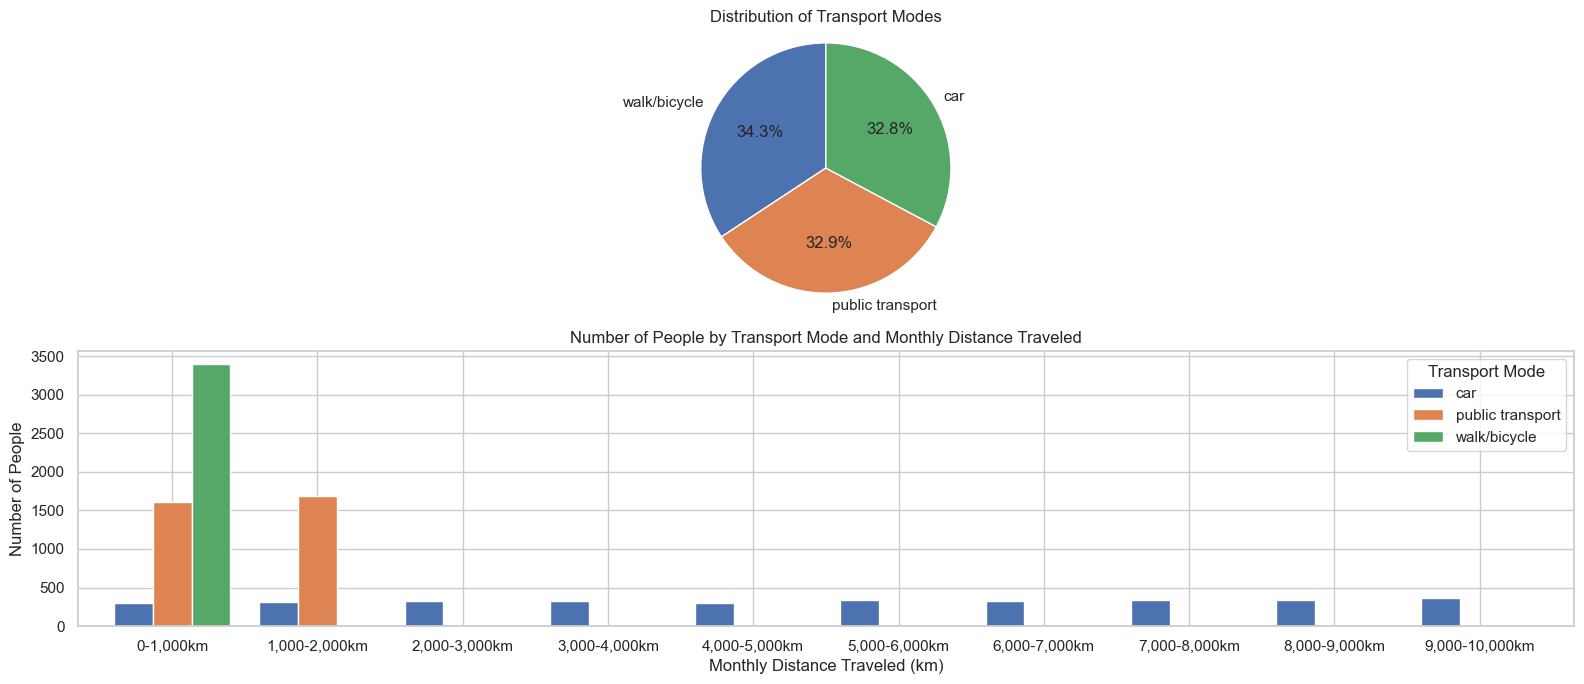

In [93]:
#chatGPT wrote the code for me


import pandas as pd
import matplotlib.pyplot as plt

# Distribution of transport modes
transport_counts = df_corr['Transport'].value_counts()
labels = [label for label in transport_counts.index]
sizes = transport_counts.values

# Create categories for Vehicle_Monthly_Distance_Km with 10 bins
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
distance_labels = ["0-1,000km", "1,000-2,000km", "2,000-3,000km", "3,000-4,000km", "4,000-5,000km", 
                   "5,000-6,000km", "6,000-7,000km", "7,000-8,000km", "8,000-9,000km", "9,000-10,000km"]
df_corr['Distance_Category'] = pd.cut(df_corr['Vehicle_Monthly_Distance_Km'], bins=bins, labels=distance_labels)

# Calculate the distribution of transport modes within each Distance_Category
counts = df_corr.groupby(['Distance_Category', 'Transport'], observed=True).size().unstack(fill_value=0)

# Create the combined plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 7))


# Pie chart
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title("Distribution of Transport Modes")

# Bar plot
counts.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Number of People by Transport Mode and Monthly Distance Traveled')
axes[1].set_xlabel('Monthly Distance Traveled (km)')
axes[1].set_ylabel('Number of People')
axes[1].legend(title='Transport Mode')
plt.xticks(rotation=0)


# Show the combined plot
plt.tight_layout()
plt.show()


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_41260/623801153.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y='Transport', x='Vehicle_Monthly_Distance_Km', data=df_corr, palette="Set2")


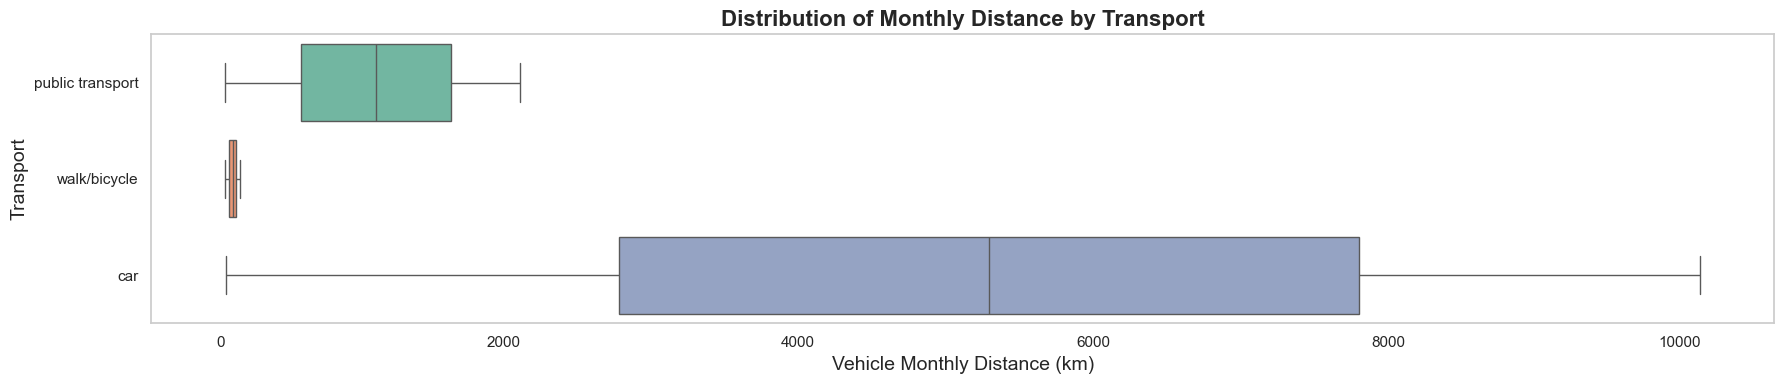

In [94]:
#chatGPT wrote the code for me


import matplotlib.pyplot as plt
import seaborn as sns

# Create the boxplot
plt.figure(figsize=(18, 4))  # Increase height for better readability
sns.set(style="whitegrid")  # Set background style to "whitegrid"

# Create the boxplot with color palette
ax = sns.boxplot(y='Transport', x='Vehicle_Monthly_Distance_Km', data=df_corr, palette="Set2")

# Add title and axis labels
plt.title('Distribution of Monthly Distance by Transport', fontsize=16, weight='bold')
plt.xlabel('Vehicle Monthly Distance (km)', fontsize=14)
plt.ylabel('Transport', fontsize=14)

# Remove grid lines
ax.grid(False)

# Rotate X-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

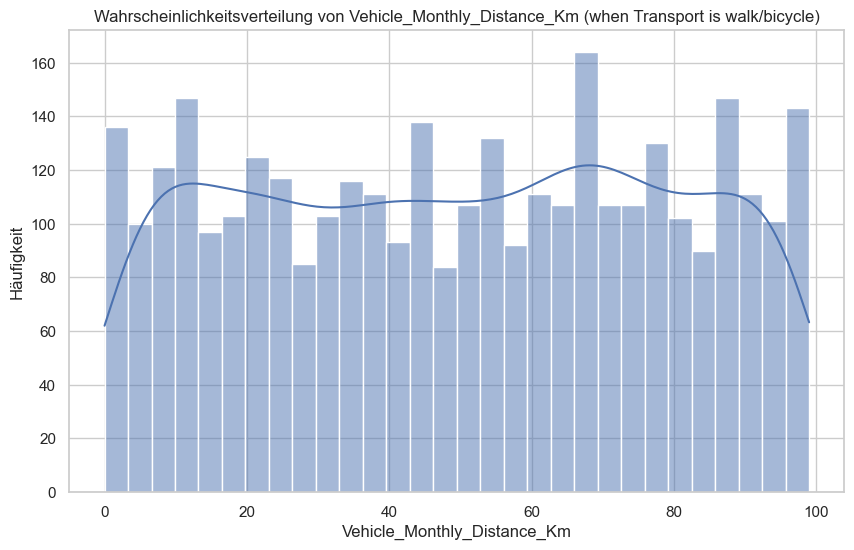

count    3427.000000
mean       49.770937
std        29.142378
min         0.000000
25%        24.000000
50%        50.000000
75%        75.000000
max        99.000000
Name: Vehicle_Monthly_Distance_Km, dtype: float64

In [95]:
#chatGPT did the programming
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Daten filtern
filtered_data = df_corr[df_corr['Transport'] == 'walk/bicycle']

# Statistische Beschreibung
description = filtered_data['Vehicle_Monthly_Distance_Km'].describe()

# Visualisierung
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['Vehicle_Monthly_Distance_Km'], kde=True, bins=30)
plt.title('Wahrscheinlichkeitsverteilung von Vehicle_Monthly_Distance_Km (when Transport is walk/bicycle)')
plt.xlabel('Vehicle_Monthly_Distance_Km')
plt.ylabel('Häufigkeit')
plt.show()

description

In [96]:
#chatGPT did the programming

import pandas as pd

# Daten filtern und NaN/inf Werte handhaben
filtered_data = df_corr[df_corr['Transport'] == 'walk/bicycle']
filtered_data = filtered_data.dropna(subset=['Vehicle_Monthly_Distance_Km'])

# Häufigkeiten berechnen
distance_counts = filtered_data['Vehicle_Monthly_Distance_Km'].value_counts().reset_index()
distance_counts.columns = ['Vehicle_Monthly_Distance_Km', 'Count (when Transport is walk/bicycle)']

# Neues DataFrame anzeigen
distance_counts

,Vehicle_Monthly_Distance_Km,Count (when Transport is walk/bicycle)
0,92,55
1,7,51
2,69,50
3,24,48
4,98,47
...,...,...
95,55,24
96,84,24
97,36,23
98,23,23


In [97]:
#chatGPT did the programming

import pandas as pd

# Daten filtern und NaN/inf Werte handhaben
filtered_data = df_corr[df_corr['Transport'] == 'public transport']
filtered_data = filtered_data.dropna(subset=['Vehicle_Monthly_Distance_Km'])

# Häufigkeiten berechnen
distance_counts = filtered_data['Vehicle_Monthly_Distance_Km'].value_counts().reset_index()
distance_counts.columns = ['Vehicle_Monthly_Distance_Km', 'Count (when Transport is walk/bicycle)']

# Neues DataFrame anzeigen
distance_counts

,Vehicle_Monthly_Distance_Km,Count (when Transport is walk/bicycle)
0,1507,7
1,1046,7
2,520,6
3,1159,6
4,1886,6
...,...,...
1585,1496,1
1586,785,1
1587,991,1
1588,1771,1


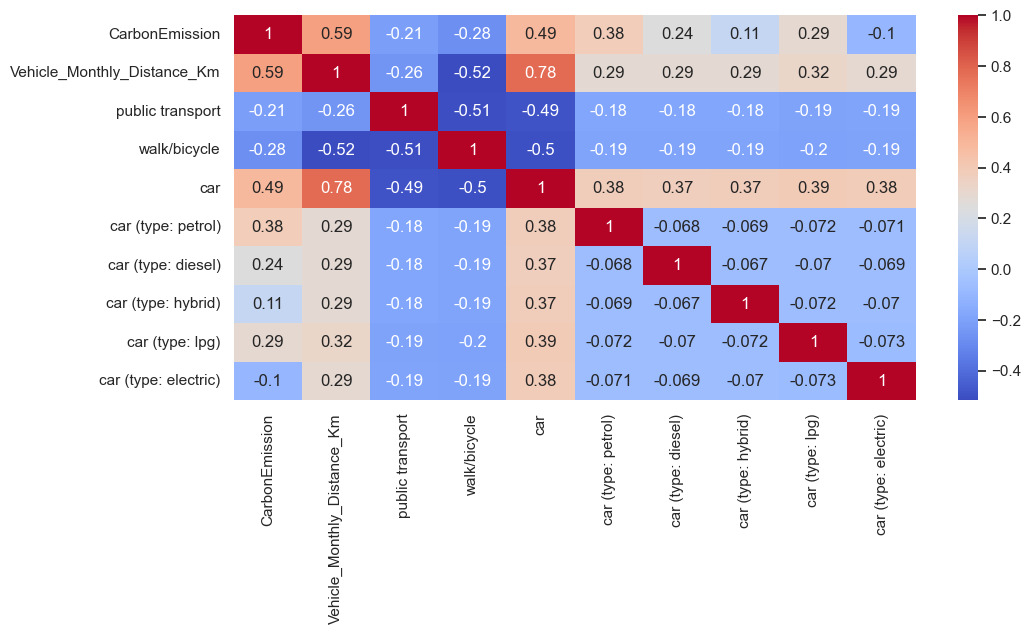

In [98]:
#correlation metric
import matplotlib.pyplot as plt

#correlations = df[column_for_correlation].corr()
correlations = df_corr[['CarbonEmission', 'Vehicle_Monthly_Distance_Km', 'public transport', 'walk/bicycle', 'car',
       'car (type: petrol)', 'car (type: diesel)', 'car (type: hybrid)',
       'car (type: lpg)', 'car (type: electric)']].corr()
plt.figure(figsize=(11, 5))  #size of figure
sns.heatmap(correlations, cmap="coolwarm", annot=True)
plt.show()

there is a high correlation of:
* -0.52 between 'Vehicle_Monthly_Distance_Km' and 'Transport: walk/bicycle'. It makes sense that walking persons don't travel many km each month and that a person who has only a short distance to travel might walk
* 0.78 between 'Vehicle_Monthly_Distance_Km' and 'Transport: car'.

Due to the correlation between the variables 'Vehicle_Monthly_Distance_Km' and 'Transport' a linear Regression (where we want to use both variables) might not be best model  - but we will do it anyway

# **variables "Transport" and "Vehicle Type"**
**I want to combined information of both variables into one and get rid of the NaN-entries in "Vehicle Type"**

In [99]:
#there are NaN-entries in "Vehicle Type"
df.isna().sum()

Body_Type                           0
Sex                                 0
Diet                                0
How_Often_Shower                    0
Heating_Energy_Source               0
Transport                           0
Vehicle_Type                     6721
Social_Activity                     0
Monthly_Grocery_Bill                0
Frequency_of_Traveling_by_Air       0
Vehicle_Monthly_Distance_Km         0
Waste_Bag_Size                      0
Waste_Bag_Weekly_Count              0
How_Long_TV_PC_Daily_Hour           0
How_Many_New_Clothes_Monthly        0
How_Long_Internet_Daily_Hour        0
Energy_efficiency                   0
Recycling                           0
Cooking_With                        0
CarbonEmission                      0
dtype: int64

In [100]:
##test

#test: if "Transport"=="public transport" then "Vehicle Type"==NaN
assert df[df["Transport"]=="public"]["Vehicle_Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "walk/bicycle" then "Vehicle Type"==NaN
assert df[df["Transport"]=="walk/bicycle"]["Vehicle_Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "Transport"=="private" then "Vehicle Type"!=NaN
assert not ((df["Transport"]=="private") & (df["Vehicle_Type"].isna())).any() #any weil gibt es irgendein True? False heißt es gibt kein einziges True

In [101]:
list(df['Vehicle_Type'].unique())

[nan,
 'car (type: petrol)',
 'car (type: diesel)',
 'car (type: hybrid)',
 'car (type: lpg)',
 'car (type: electric)']

In [102]:
##create new column "Transport Vehicle Type" 
df["Transport_Vehicle_Type"]=df["Vehicle_Type"] #create a new column
df.loc[df["Transport_Vehicle_Type"].isna(), "Transport_Vehicle_Type"] = df["Transport"] # Werte aus 'Transport' übernehmen, wenn 'Vehicle Type' NaN ist


##add "Transport Vehicle Type" to one-hot-encoding-list
if "Transport_Vehicle_Type" not in variables_for_one_hot_encoded: ##wenn es noch nicht hinzugefügt wurde bzw is one element in the list already?
    variables_for_one_hot_encoded.append("Transport_Vehicle_Type") 

##veranschaulichen der neuen Spalten und ihrer Werte
df[["Transport","Vehicle_Type","Transport_Vehicle_Type"]].head()

,Transport,Vehicle_Type,Transport_Vehicle_Type
0,public transport,NaN,public transport
1,walk/bicycle,NaN,walk/bicycle
2,car,car (type: petrol),car (type: petrol)
3,walk/bicycle,NaN,walk/bicycle
4,car,car (type: diesel),car (type: diesel)


In [103]:
#Zusammenfassung welche Werte die mehreren Spalten ist

print(df.groupby(["Transport","Vehicle_Type","Transport_Vehicle_Type"]).size()) #ich GLAUBE das problem ist: Python lässt die mit "NaN" unter dem Tisch fallen

pd.DataFrame(df.groupby(["Transport","Transport_Vehicle_Type"]).size())

Transport  Vehicle_Type          Transport_Vehicle_Type
car        car (type: diesel)    car (type: diesel)        622
           car (type: electric)  car (type: electric)      671
           car (type: hybrid)    car (type: hybrid)        642
           car (type: lpg)       car (type: lpg)           697
           car (type: petrol)    car (type: petrol)        647
dtype: int64


0
Transport        Transport_Vehicle_Type      
car              car (type: diesel)       622
                 car (type: electric)     671
                 car (type: hybrid)       642
                 car (type: lpg)          697
                 car (type: petrol)       647
public transport public transport        3294
walk/bicycle     walk/bicycle            3427

# **variables "Recycling" and "Cooking_With" (these variables allow multiple answers)**

In [104]:
##create new column: dummy-variables for Recycling
unique_values_Recycling= set([item for sublist in df['Recycling'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Recycling-Möglichkeiten
# Für jede einzigartige Recycling-Möglichkeit eine neue Spalte hinzufügen und mit 0 oder 1 füllen
for item in unique_values_Recycling:
    df['Recycling_'+str(item)] = df['Recycling'].apply(lambda x: 1 if item in x else 0)

##create new column: dummy-variables for Cooking-with
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Cooking_With-Möglichkeiten
# Für jede einzigartige Cooking_With-Möglichkeit eine neue Spalte hinzufügen und mit 0 oder 1 füllen
for item in unique_values_cooking_With:
    df['Cooking_With_'+str(item)] = df['Cooking_With'].apply(lambda x: 1 if item in x else 0)


##add new columns to "variables_quantitative"-list for lineare Regression
columns_recycling=['Recycling_'+str(item) for item in unique_values_Recycling] #liste mit Spalten-Namen
if columns_recycling[0] not in variables_quantitative: ##wenn es noch nicht hinzugefügt wurde bzw is one element in the list already?
    variables_quantitative += columns_recycling
columns_cooking_with=['Cooking_With_'+str(item) for item in unique_values_cooking_With] #liste mit Spalten-Namen
if columns_cooking_with[0] not in variables_quantitative: ##wenn es noch nicht hinzugefügt wurde bzw is one element in the list already?
    variables_quantitative += columns_cooking_with


#Person 282 cooks with "nothing" deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden, person 283 who doesn't recycle deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden
#Darstellung 
df.iloc[282:284, -13:] 

,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type,Recycling_Paper,Recycling_Plastic,Recycling_Glass,Recycling_Metal,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Airfryer,Cooking_With_Stove,Cooking_With_Grill
282,"['Paper', 'Plastic', 'Metal']",[],1484,public transport,1,1,0,1,0,0,0,0,0
283,[],"['Stove', 'Grill', 'Airfryer']",2955,public transport,0,0,0,0,0,0,1,1,1


# **One-Hot-Encoding for categorical variables & scaling of feature **

In [105]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df[variables_quantitative + variables_for_one_hot_encoded]  

##### one-hot-encoding ############################################

# Create the ColumnTransformer using the list "variables_for_one_hot_encoded"
cf = ColumnTransformer(
    [(col, OneHotEncoder(drop="first"), [col]) for col in variables_for_one_hot_encoded],  
    remainder="passthrough")

cf.fit(X)
X_transformed = cf.transform(X) # Data after scaling


##### scaling ############################################
# scaling so number are between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_transformed)
X_transformed_scaled = scaler.transform(X_transformed)  # Data after scaling



In [106]:
X_transformed[0]

array([  0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   1.,   0., 230., 210.,   4.,   7.,
        26.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.])

In [107]:
X.head(1)

,Monthly_Grocery_Bill,Vehicle_Monthly_Distance_Km,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Recycling_Paper,Recycling_Plastic,Recycling_Glass,Recycling_Metal,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Airfryer,Cooking_With_Stove,Cooking_With_Grill,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Social_Activity,Frequency_of_Traveling_by_Air,Waste_Bag_Size,Energy_efficiency,Transport_Vehicle_Type
0,230,210,4,7,26,1,0,0,0,1,1,0,0,1,0,overweight,female,pescatarian,daily,coal,often,frequently,large,No,public transport


# **linear Regression**

In [108]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

y = df["CarbonEmission"]

##### Splitting the dataset into train and test set ########################################
X_train, X_test, y_train, y_test = train_test_split(X_transformed_scaled,y, train_size = 0.75)

###### Implementing the linear model ######################################################
model = LinearRegression()
model.fit(X_train, y_train)

    ##Evaluating the Model
print(f"average R-squared score (from test-set): {model.score(X_test, y_test):.4f}")  
print(f"average R-squared score (from train-set): {model.score(X_train, y_train):.4f}") 

average R-squared score (from test-set): 0.9270
average R-squared score (from train-set): 0.9360


# **Regression Equation**

In [109]:
# Get the feature names after one-hot encoding. I do NOT understand that - chatGTP did the programming
ohe_feature_names = []
for col, transformer, _ in cf.transformers_[:-1]:
    ohe_feature_names.extend(transformer.get_feature_names_out([col]))
all_feature_names = ohe_feature_names + variables_quantitative

In [110]:
#Regression Equation
regression_equation ="Regression Equation: CarbonEmission = "
for variable, slope in list(zip(all_feature_names, model.coef_)):
   regression_equation += "(" + str(round(slope,3)) + "*" + variable + ") + "
regression_equation += str(round(model.intercept_,3)) + " + Error\n"
print(regression_equation)

Regression Equation: CarbonEmission = (417.019*Body_Type_obese) + (201.838*Body_Type_overweight) + (-108.898*Body_Type_underweight) + (342.21*Sex_male) + (-86.088*Diet_pescatarian) + (-161.597*Diet_vegan) + (-130.576*Diet_vegetarian) + (-7.367*How_Often_Shower_less frequently) + (21.629*How_Often_Shower_more frequently) + (19.324*How_Often_Shower_twice a day) + (-428.248*Heating_Energy_Source_electricity) + (-202.409*Heating_Energy_Source_natural gas) + (-190.154*Heating_Energy_Source_wood) + (167.125*Social_Activity_often) + (69.272*Social_Activity_sometimes) + (-646.633*Frequency_of_Traveling_by_Air_never) + (-468.072*Frequency_of_Traveling_by_Air_rarely) + (655.465*Frequency_of_Traveling_by_Air_very frequently) + (-128.145*Waste_Bag_Size_large) + (-265.201*Waste_Bag_Size_medium) + (-385.279*Waste_Bag_Size_small) + (-35.089*Energy_efficiency_Sometimes) + (-62.357*Energy_efficiency_Yes) + (-1258.271*Transport_Vehicle_Type_car (type: electric)) + (-430.356*Transport_Vehicle_Type_car (t

In [111]:
# Print the regression coefficients with feature names
print("Intercept: ", model.intercept_)
print("Coefficients:")
for feature, coef in zip(all_feature_names, model.coef_):
#    print(f"{feature}: {coef:.3f}") #für 3 Nachkommastellen
    print(f"{feature}: {coef:}") 

Intercept:  1683.290846075739
Coefficients:
Body_Type_obese: 417.01920926599007
Body_Type_overweight: 201.83780432236267
Body_Type_underweight: -108.89755643324352
Sex_male: 342.20977040959883
Diet_pescatarian: -86.08836047993265
Diet_vegan: -161.59680148711936
Diet_vegetarian: -130.57629977267837
How_Often_Shower_less frequently: -7.366622397029889
How_Often_Shower_more frequently: 21.629424209625906
How_Often_Shower_twice a day: 19.323926356000808
Heating_Energy_Source_electricity: -428.24845119889295
Heating_Energy_Source_natural gas: -202.40877467305558
Heating_Energy_Source_wood: -190.1540573318689
Social_Activity_often: 167.12450840381138
Social_Activity_sometimes: 69.27197682632114
Frequency_of_Traveling_by_Air_never: -646.6334870782531
Frequency_of_Traveling_by_Air_rarely: -468.0723324160727
Frequency_of_Traveling_by_Air_very frequently: 655.4652715116225
Waste_Bag_Size_large: -128.14492338135886
Waste_Bag_Size_medium: -265.200895273818
Waste_Bag_Size_small: -385.27878173934874

# **Prediction/Estimation of the Carbon Emission of a random person**

In [112]:
print("actual CarbonEmission of first 2 persons: ", df.at[0, 'CarbonEmission'], df.at[1, 'CarbonEmission'])
df.head()


actual CarbonEmission of first 2 persons:  2238 1892


,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type,Recycling_Paper,Recycling_Plastic,Recycling_Glass,Recycling_Metal,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Airfryer,Cooking_With_Stove,Cooking_With_Grill
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238,public transport,0,0,0,1,1,0,0,1,0
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892,walk/bicycle,0,0,0,1,0,1,0,1,0
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595,car (type: petrol),0,0,0,1,1,1,0,0,0
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074,walk/bicycle,1,1,1,1,0,1,1,0,1
4,obese,female,vegetarian,daily,coal,car,car (type: diesel),often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743,car (type: diesel),1,0,0,0,1,0,0,0,0


In [113]:
#manuell Daten eingeben
X_pred = pd.DataFrame([
#  [230, 210, 4,7,26,1,False,1,0,0,True,0,0,0,1,"overweight","female","pescatarian","daily","coal","often","frequently","large","No","public"],
  [114, 9, 3,9,38,5,False,1,0,0,False,1,0,0,1,"obese","female","vegetarian","less frequently","natural gas","often","rarely","extra large","No","walk/bicycle"]  
], columns=['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km','Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour', 
            'Recycling_Glass', 'Recycling_Metal', 'Recycling_Plastic', 'Recycling_Paper', 'Cooking_With_Oven', 'Cooking_With_Microwave', 'Cooking_With_Grill', 'Cooking_With_Airfryer',
            'Cooking_With_Stove', 'Body_Type', 'Sex', 'Diet', 'How_Often_Shower', 'Heating_Energy_Source', 'Social_Activity', 'Frequency_of_Traveling_by_Air', 'Waste_Bag_Size', 
            'Energy_efficiency', 'Transport_Vehicle_Type'])
    #columns=variables_quantitative + variables_for_one_hot_encoded)

print("predicted CarbonEmission of second person: ", model.predict(scaler.transform(cf.transform(X_pred))))


#Daten nicht manuell eingegeben sondern aus dem Data-Frame übernommen
X_pred= df.loc[0:1] #first 2 persons
print("predicted CarbonEmission of first 2 persons: ", model.predict(scaler.transform(cf.transform(X_pred))))


print("actual CarbonEmission of first 2 persons: ", df.at[0, 'CarbonEmission'], df.at[1, 'CarbonEmission'])

df.iloc[0:2, :30] #first 2 persons, first 30 columns

predicted CarbonEmission of first 2 persons:  [1962.1778474]
predicted CarbonEmission of first 2 persons:  [2262.67501364 1962.1778474 ]
actual CarbonEmission of first 2 persons:  2238 1892


,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type,Recycling_Paper,Recycling_Plastic,Recycling_Glass,Recycling_Metal,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Airfryer,Cooking_With_Stove,Cooking_With_Grill
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238,public transport,0,0,0,1,1,0,0,1,0
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892,walk/bicycle,0,0,0,1,0,1,0,1,0


In [114]:
model.predict(X_test)

array([3386.50719815, 3546.06009776, 2281.43444072, ..., 1518.40782662,
        616.17501743, 3250.52159145])